## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# less common imports
import matplotlib.image as mpimg
from pygam import LinearGAM, GAM, s, l
from sklearn import preprocessing
from scipy import stats
from scipy import spatial
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import shutil
import gc
from seaborn import clustermap
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

/home/serhiy/Desktop/code/2_single_cell/dulac_kaplan2023_dev_regulation_snRNAseq_scATACseq_mouse_hbc04623/data/hotspot_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 pynndescent==0.5.8


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [3]:
# inhibitory has 22 colors
v_colors = ['#ffc857', '#c6d5c0', '#558140', '#6e0614', '#8b3843', 
            '#a86a72', '#c59ba1', '#8eab80', '#ecd1c8', '#484848', 
            '#92afc2', '#255f85', '#e2cdd0', '#c77459', '#daa290', 
            'fuchsia', '#b44622', '#1c5701', '#a3a3a3',
            'red', 'yellow', 'lime' ]

## **Format logTMM data from limma-voom into workable form for GAM curve fitting**

In [35]:
# Set path and read in logTMM normalized data from limma-voom output directories
# the directories are generated by 08_limma-voom.R
dt_path = "./data/limma_voom/"
dt_fls = os.listdir(path=dt_path)

In [36]:
# read in anndata for obs
# adata = sc.read_h5ad( "./data/2023-05-16_input/seurat.excitatory_select.h5ad")
# adata = sc.read_h5ad("./data/2023-05-16_input/seurat.inhibitory_select.h5ad")
adata = sc.read_h5ad("./data/2023-05-16_input/seurat.merged.h5ad")
obs_df = adata.obs.copy()
# clean up dataframe by dropping all duplicates of batch entries
# obs_df.drop_duplicates(subset='batch', keep="first", inplace=True)

In [37]:
dt_fls

['e-A1_pseudo-bulk-cts_min10.csv',
 'e-A1_obs-cts_min10.csv',
 'e-A2_pseudo-bulk-cts_min10.csv',
 'e-A2_obs-cts_min10.csv',
 'e-A3_pseudo-bulk-cts_min10.csv',
 'e-A3_obs-cts_min10.csv',
 'e-A4_pseudo-bulk-cts_min10.csv',
 'e-A4_obs-cts_min10.csv',
 'e-A5_pseudo-bulk-cts_min10.csv',
 'e-A5_obs-cts_min10.csv',
 'e-A6_pseudo-bulk-cts_min10.csv',
 'e-A6_obs-cts_min10.csv',
 'e-B1_pseudo-bulk-cts_min10.csv',
 'e-B1_obs-cts_min10.csv',
 'e-B2_pseudo-bulk-cts_min10.csv',
 'e-B2_obs-cts_min10.csv',
 'e-C1_pseudo-bulk-cts_min10.csv',
 'e-C1_obs-cts_min10.csv',
 'e-C2_pseudo-bulk-cts_min10.csv',
 'e-C2_obs-cts_min10.csv',
 'e-C3_pseudo-bulk-cts_min10.csv',
 'e-C3_obs-cts_min10.csv',
 'e-C4_pseudo-bulk-cts_min10.csv',
 'e-C4_obs-cts_min10.csv',
 'e-C5_pseudo-bulk-cts_min10.csv',
 'e-C5_obs-cts_min10.csv',
 'e-C6_pseudo-bulk-cts_min10.csv',
 'e-C6_obs-cts_min10.csv',
 'e-C7_pseudo-bulk-cts_min10.csv',
 'e-C7_obs-cts_min10.csv',
 'e-C8_pseudo-bulk-cts_min10.csv',
 'e-C8_obs-cts_min10.csv',
 'e-C9_p

In [38]:
# select for limma dev-traj directories
###############################
dt_oi = "glimma_"
###############################
oi_fls = [ii for ii in dt_fls if dt_oi in ii]
oi_fls

['glimma_e-A1',
 'glimma_e-A2',
 'glimma_e-A3',
 'glimma_e-A4',
 'glimma_e-A5',
 'glimma_e-A6',
 'glimma_e-B1',
 'glimma_e-B2',
 'glimma_e-C1',
 'glimma_e-C2',
 'glimma_e-C3',
 'glimma_e-C4',
 'glimma_e-C5',
 'glimma_e-C6',
 'glimma_e-C7',
 'glimma_e-C8',
 'glimma_e-C9',
 'glimma_e-F1',
 'glimma_e-H1',
 'glimma_e-H10',
 'glimma_e-H2',
 'glimma_e-H3',
 'glimma_e-H4',
 'glimma_e-H5',
 'glimma_e-H6',
 'glimma_e-H7',
 'glimma_e-H8',
 'glimma_e-H9',
 'glimma_e-L2',
 'glimma_e-L3',
 'glimma_e-L4',
 'glimma_e-L5',
 'glimma_e-L6',
 'glimma_e-L7',
 'glimma_e-L8',
 'glimma_e-M1',
 'glimma_e-M10',
 'glimma_e-M2',
 'glimma_e-M3',
 'glimma_e-M4',
 'glimma_e-M5',
 'glimma_e-M6',
 'glimma_e-M7',
 'glimma_e-M8',
 'glimma_e-M9',
 'glimma_e-N1',
 'glimma_e-N10',
 'glimma_e-N11',
 'glimma_e-N2',
 'glimma_e-N3',
 'glimma_e-N4',
 'glimma_e-N5',
 'glimma_e-N6',
 'glimma_e-N7',
 'glimma_e-N8',
 'glimma_e-N9',
 'glimma_e-P1',
 'glimma_e-P2',
 'glimma_e-P3',
 'glimma_e-P4',
 'glimma_e-T1',
 'glimma_e-T2',
 'gl

In [28]:
# bk_df = pd.read_csv( f"data/dev_deg_v4/avpe_logTMM_cts.csv", index_col=[0])
# columns = bk_df.columns.values
# print(columns)
# fl_itr = oi_fls[0]
# key = fl_itr.replace("glimma_", "")
# results = pd.read_table( f"{dt_path}{fl_itr}/results_file.txt")
# find and pull all results columns 
# Results.X0-X1 between time points
# res_cols = [ii for ii in results.columns if 'Res' in ii]
# genes X comparisons
# res_df = results[res_cols]
    
# find all genes signifcant for any stage comparison
# sig_mk = np.any((res_df!=0).values, axis = 1)
# test = results.index.values[sig_mk]
 
# set to dict
# sig_genes_key = results.index.values[sig_mk]
# read in pseudo-bulk logTMM
# bk_df = pd.read_csv( f"{dt_path}{fl_itr}/logTMM_cts.csv", index_col=[0])
# columns = bk_df.columns.values
# columns_dict = {}
# for c in columns:
#    [s_cell_type, s_sample] = [s for s in c.split('..')]
     # X6..3 => 3
# columns_dict[c] = s_sample
# columns_buf = sorted(columns_dict.items(), key=lambda x:x[1])
# columns_sorted = [x[0] for x in columns_buf]
# columns_sorted

# bk_df = bk_df[columns_sorted]
#bk_df
# len(sig_genes_key)
# reduce bulk data to sig genes only
# sig_genes[key]
# sig_bk_df = bk_df.iloc[sig_genes_key]
# sig_bk_df
# print(key)
# set to dict
# logTMMs[key] = sig_bk_df
# sig_genes_key

array([   0,   10,   11, ..., 8566, 8567, 8571])

In [39]:
# 1) read in results files for each and pull sig genes
# 2) read in pseudo-bulk logTMM from limma voom
#key="avpe"
sig_genes = {}
logTMMs = {}

for fl_itr in oi_fls:
    key = key = fl_itr.replace("glimma_", "")
    results = pd.read_table( f"{dt_path}{fl_itr}/results_file.txt")
    # find and pull all results columns 
    # Results.X0-X1 between time points
    res_cols = [ii for ii in results.columns if 'Res' in ii]
    # genes X comparisons
    res_df = results[res_cols]
    
    # find all genes signifcant for any stage comparison
    sig_mk = np.any((res_df!=0).values, axis = 1)

    # set to dict
    sig_genes[key] = results.index.values[sig_mk]
    # read in pseudo-bulk logTMM
    bk_df = pd.read_csv( f"{dt_path}{fl_itr}/logTMM_cts.csv", index_col=[0])
    columns = bk_df.columns.values
    columns_dict = {}
    for c in columns:
        [s_cell_type, s_sample] = [s for s in c.split('..')]
        # X6..3 => 3
        columns_dict[c] = s_sample
    columns_buf = sorted(columns_dict.items(), key=lambda x:x[1])
    columns_sorted = [x[0] for x in columns_buf]
    columns_sorted
    # clean up columns labels, make them batch
    # they are batches already for us? [1] makes ages
    #bk_df.columns = [ii.split('..')[1] for ii in bk_df.columns.values]
    # order columns by age of maturation
    #batch_mk = np.in1d(adata.uns['batch_order'], bk_df.columns)
    #batch_mk = np.in1d(batch_order, bk_df.columns)
    #batch_mk
    #batch_order_itr = np.array(batch_order)[batch_mk]
    bk_df = bk_df[columns_sorted]
    #bk_df
    # len(sig_genes[key])
    # reduce bulk data to sig genes only
    # sig_genes[key]
    sig_bk_df = bk_df.iloc[sig_genes[key]]
    sig_bk_df
    # print(key)
    # set to dict
    logTMMs[key] = sig_bk_df
# sig_genes

In [40]:
sig_genes

{'e-A1': array([   0,   10,   11, ..., 8566, 8567, 8571]),
 'e-A2': array([   0,   15,   16, ..., 6888, 6892, 6894]),
 'e-A3': array([   0,    1,    2, ..., 4908, 4909, 4910]),
 'e-A4': array([   0,    6,    8, ..., 3343, 3344, 3347]),
 'e-A5': array([   0,   12,   16, ..., 4626, 4628, 4629]),
 'e-A6': array([ 165,  258,  274,  301,  319,  352,  397,  421,  461,  502,  546,
         578,  593,  622,  876,  987, 1011, 1050, 1127, 1130, 1186, 1201,
        1202, 1313, 1343, 1374, 1389, 1432, 1468, 1577, 1611, 1632, 1690]),
 'e-B1': array([   6,   11,   14, ..., 4692, 4693, 4696]),
 'e-B2': array([   5,    9,   11,   16,   17,   20,   22,   32,   38,   47,   58,
          65,   70,   71,   73,   74,   80,   85,   86,   92,   97,  100,
         111,  115,  125,  128,  137,  138,  140,  148,  151,  160,  167,
         179,  185,  186,  189,  193,  206,  207,  211,  212,  213,  220,
         224,  232,  255,  256,  264,  266,  273,  274,  275,  278,  279,
         288,  292,  297,  303,  319

In [42]:
# save to use in future analysis
nmc.save_obj(logTMMs, f"./data/dev_deg_v8/logTMMs.pkl")

In [43]:
for iii, jjj in sig_genes.items():
    print( iii, jjj.shape)

e-A1 (4015,)
e-A2 (1195,)
e-A3 (2890,)
e-A4 (1151,)
e-A5 (1590,)
e-A6 (33,)
e-B1 (1624,)
e-B2 (679,)
e-C1 (800,)
e-C2 (575,)
e-C3 (3577,)
e-C4 (7657,)
e-C5 (2458,)
e-C6 (2005,)
e-C7 (3468,)
e-C8 (2087,)
e-C9 (631,)
e-F1 (1107,)
e-H1 (9,)
e-H10 (300,)
e-H2 (2352,)
e-H3 (1386,)
e-H4 (501,)
e-H5 (2751,)
e-H6 (1718,)
e-H7 (1990,)
e-H8 (1230,)
e-H9 (890,)
e-L2 (777,)
e-L3 (2261,)
e-L4 (1785,)
e-L5 (727,)
e-L6 (1428,)
e-L7 (27,)
e-L8 (1144,)
e-M1 (234,)
e-M10 (1339,)
e-M2 (855,)
e-M3 (840,)
e-M4 (1016,)
e-M5 (1424,)
e-M6 (3602,)
e-M7 (631,)
e-M8 (1111,)
e-M9 (2725,)
e-N1 (2162,)
e-N10 (919,)
e-N11 (496,)
e-N2 (1181,)
e-N3 (888,)
e-N4 (1199,)
e-N5 (1344,)
e-N6 (121,)
e-N7 (285,)
e-N8 (295,)
e-N9 (1626,)
e-P1 (1317,)
e-P2 (1844,)
e-P3 (1230,)
e-P4 (1854,)
e-T1 (4389,)
e-T2 (1884,)
e-X1 (2828,)
i-B1 (5253,)
i-B10 (1214,)
i-B11 (4280,)
i-B13 (1928,)
i-B2 (3881,)
i-B3 (4072,)
i-B4 (2731,)
i-B5 (3240,)
i-B6 (4776,)
i-B7 (1110,)
i-B8 (3126,)
i-B9 (941,)
i-C1 (4149,)
i-C2 (1081,)
i-H1 (4218,)
i-H10 

In [17]:
# example logTMM dataframe
logTMMs['i-B1'].head()

,i.B1..e16f,i.B1..e16m_apr23,i.B1..e18f,i.B1..e18f_may22,i.B1..e18m,i.B1..e18m_may22,i.B1..p0f,i.B1..p0f2,i.B1..p0m_july,i.B1..p10f,...,i.B1..p28m,i.B1..p28m_may22,i.B1..p4f,i.B1..p4f_oct,i.B1..p4m,i.B1..p4m_mar23,i.B1..p65f_apr23,i.B1..p65f_april,i.B1..p65m_april,i.B1..p65m_aug
Xkr4,9.875470,9.776237,9.691923,9.430306,9.819623,9.697179,9.575713,9.693702,9.804442,9.333805,...,9.608604,9.487149,9.576840,9.958170,9.629906,9.621502,9.521372,9.517490,9.338353,9.522297
Gm1992,5.851207,5.232553,6.053854,5.826121,5.776116,5.458429,5.512119,6.108162,5.032528,5.401497,...,5.577309,5.609402,6.163097,6.171596,5.834913,5.429569,6.393374,6.384795,5.744048,6.369843
Lypla1,4.648846,4.656496,4.351695,4.269053,3.992352,3.011423,4.676092,4.772100,5.182934,5.130299,...,5.938865,4.707842,3.981086,3.803717,4.712179,5.054644,5.429095,5.926005,5.931286,6.200492
Rgs20,5.023683,5.472803,5.042344,5.925932,5.542831,4.289349,5.791760,5.008681,5.328304,6.122667,...,6.394703,5.658588,5.835180,6.454729,5.651231,4.148809,6.777269,6.003072,5.956459,6.268452
Oprk1,3.914384,3.921607,4.835120,3.011423,3.011423,4.666420,4.531199,3.576861,4.380674,5.698643,...,4.987348,6.124663,4.500035,4.982421,5.409256,3.011423,5.769054,4.672944,6.055941,6.575318


### Trends on year scale are fit to arcsinh transformed ages using a cofactor which best linearizes the intervals between ages 

In [44]:
# make numerical age, gestation - 20 days, embryonic = value, post-natal = +20
# create numerical age -day-wise
# a cell type could have not all the ages - so we have to iterate
# key_itr = "e-A1"
# key_itr = "i-M8"
# ax_age
ai_age = []
sample_age = {}
for key_itr in logTMMs.keys():
    sig_df = logTMMs[key_itr]
    ax_age = [s.split("..")[1].split("_")[0] for s in sig_df.columns]
    # only for samples which are part of pseudobulk
    for age in ax_age:
        i_age = 0
        if age[0] == "e":
            i_age = int(age[1:3])
        elif age[0:2] == "p0":
            i_age = 20
        elif age[0:2] == "p4":
            i_age = 24
        else:
            i_age = int(age[1:3]) + 20
        #ai_age.append(i_age)
        sample_age[age] = i_age
ai_age = sorted(sample_age.values())
#len(sample_age)
#ai_age
sample_age

{'e16f': 16,
 'e16m': 16,
 'e18f': 18,
 'e18m': 18,
 'p0f2': 20,
 'p0m': 20,
 'p10f': 30,
 'p10m': 30,
 'p18f': 38,
 'p18m': 38,
 'p28f': 48,
 'p28m': 48,
 'p4f': 24,
 'p4m': 24,
 'p65f': 85,
 'p65m': 85,
 'p0f': 20}

In [45]:
from scipy.optimize import fmin
from scipy.stats import pearsonr

# use numpy unique instead of pandas so results are sorted
# uq_num_ages = np.unique(adata.obs['age'])
uq_num_ages = np.unique(ai_age)
print(uq_num_ages)
def f(c, x=uq_num_ages):
    xx = np.arcsinh(x/c)
    yy = np.arange(0, len(x))
    corr = pearsonr(xx, yy)[0]
    return( 1 - corr)

[16 18 20 24 30 38 48 85]


In [24]:
# c = 0.000000000000001
# x = uq_num_ages
# xx = np.arcsinh(x/c)
# yy = np.arange(0, len(x))
# print(pearsonr(xx, yy)[0])

0.9680072698965008


In [47]:
# rescaling by fitting arcsinh cofactor such that it minimizes anti-correlation
# optimize a function using simplex algorithm
# 0.40 - initial guess in Lister
# not optimizing in our case
lin_cf = fmin(f, 0.5)[0]
adata.uns['arcsinh_cofactor'] = lin_cf
lin_cf

Optimization terminated successfully.
         Current function value: 0.031993
         Iterations: 24
         Function evaluations: 48


0.00019531249999955608

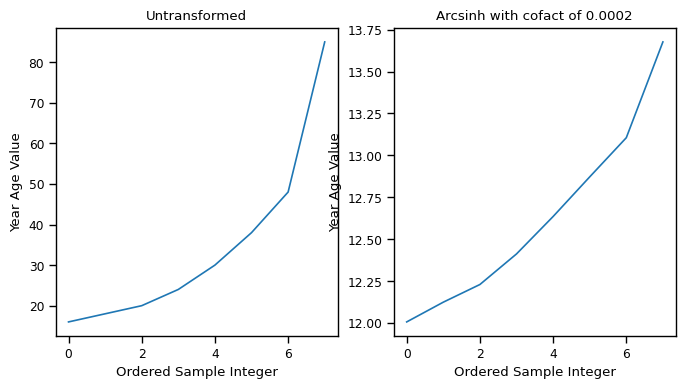

In [48]:
# check if cofactor is nearly linear with evenly placed data pts
fig,[ax0,ax1] = plt.subplots(1,2, figsize=(8,4))
ax0.plot(uq_num_ages)
ax0.set_title('Untransformed')
ax0.set_ylabel('Year Age Value')
ax0.set_xlabel('Ordered Sample Integer')
ax1.plot( np.arcsinh( uq_num_ages/lin_cf))
ax1.set_title(f"Arcsinh with cofact of {round(lin_cf,4)}")
ax1.set_ylabel('Year Age Value')
ax1.set_xlabel('Ordered Sample Integer');

In [216]:
# not sure if we really need it
# obs_df['arcsin_age'] = np.arcsinh(obs_df['age'] / lin_cf)
# obs_df['age_days'] = [sample_age[x] for x in obs_df['sample']]
# print(obs_df['age_days'])
# obs_df['arcsin_age'] = np.arcsinh(sample_age[obs_df['sample']] / lin_cf)
# print(obs_df["sample"])
#print(logTMMs["avpe"].columns)

In [31]:
# change column names in each logTMM to arcsinh age of batch
# will use these values as x-axis in curve fitting
#plot_labels = {}
# for key_itr in logTMMs.keys():
#new_cols = []
#key_itr = "avpe"
#for col_itr in logTMMs[key_itr]:
    # arcsin_age = np.arcsinh(int(sample_age[col_itr.split("..")[1]]))/lin_cf
    # age_itr = obs_df.loc[obs_df['age']==col_itr,'arcsin_age'].values[0]
    # new_cols.append( round( age_itr, ndigits=4))
    # new_cols.append(round(arcsin_age, ndigits=4))
    #plot_labels[key_itr] = [ii.split('_')[1] for ii in logTMMs[key_itr].columns]
    # plot_labels[key_itr] = [s.split('..')[1].split("_")[0] for s in logTMMs[key_itr].columns]
#logTMMs[key_itr].columns = new_cols
#print(len(new_cols))
#print(len(logTMMs[key_itr].columns))

Index(['e.A1..e16f', 'e.A2..e16f', 'e.A3..e16f', 'e.A4..e16f', 'e.A5..e16f',
       'e.A6..e16f', 'e.L8..e16f', 'e.A1..e16m_apr23', 'e.A2..e16m_apr23',
       'e.A3..e16m_apr23',
       ...
       'e.A3..p65f_april', 'e.A5..p65f_april', 'e.A6..p65f_april',
       'e.A1..p65m_april', 'e.A2..p65m_april', 'e.A3..p65m_april',
       'e.A1..p65m_aug', 'e.A2..p65m_aug', 'e.A3..p65m_aug', 'e.A4..p65m_aug'],
      dtype='object', length=138)


In [32]:
# logTMMs['avpe'].head()

,e.A1..e16f,e.A2..e16f,e.A3..e16f,e.A4..e16f,e.A5..e16f,e.A6..e16f,e.L8..e16f,e.A1..e16m_apr23,e.A2..e16m_apr23,e.A3..e16m_apr23,...,e.A3..p65f_april,e.A5..p65f_april,e.A6..p65f_april,e.A1..p65m_april,e.A2..p65m_april,e.A3..p65m_april,e.A1..p65m_aug,e.A2..p65m_aug,e.A3..p65m_aug,e.A4..p65m_aug
Slco5a1,6.814459,6.179959,6.946692,7.486520,7.534658,7.174225,7.205745,6.291363,6.801935,6.277327,...,4.414659,5.029400,4.414659,4.414659,4.414659,4.414659,4.414659,4.414659,4.414659,4.414659
Rpl7,7.307938,7.600179,7.441363,7.987180,6.789106,6.937575,7.638807,7.849508,7.721263,8.041692,...,6.714017,7.081587,6.379725,6.529050,6.226011,7.829424,7.017102,6.302055,5.279715,6.823928
Eloc,6.436060,5.786291,6.370321,6.634074,6.189311,4.414659,4.414659,6.156917,5.448022,6.442949,...,6.610647,5.915409,7.975393,5.581549,6.862647,7.302091,6.314929,5.866302,5.482554,5.573365
Cox5b,7.065740,6.120083,6.658993,6.984663,6.616428,6.829552,5.928675,7.349361,6.612591,7.237351,...,6.743782,6.916778,6.723258,6.789543,6.650154,7.262956,7.489559,7.351723,6.800849,8.393983
Actr1b,5.958535,5.975695,6.828968,6.794453,6.634615,7.180480,6.865833,6.017891,6.685403,6.870388,...,7.700856,8.200668,7.608750,4.414659,6.294505,7.636796,7.516271,7.270786,7.281779,7.576791


## **Fit GAM to each gene across stages**

In [49]:
logTMMs.items()

dict_items([('e-A1',                e.A1..e16f  e.A1..e16m_apr23  e.A1..e18f  e.A1..e18f_may22  \
Xkr4             9.871793          9.737457    9.653072          9.539108   
Pcmtd1           7.867536          7.647954    8.033313          6.820347   
Gm26901          6.141518          5.904768    6.013962          5.875167   
Sntg1            9.107829          8.748105    8.715205          8.471394   
Mcmdc2           5.057258          4.795383    3.410986          3.410986   
...                   ...               ...         ...               ...   
mt-Nd5           5.377976          7.040123    6.963493          6.385601   
mt-Cytb          6.772457          8.714170    8.439802          7.966205   
Tmlhe            5.889428          5.505431    4.518638          5.419450   
AC149090.1       9.514805          9.438483    9.546460          9.715170   
B930025P03Rik    3.410986          3.410986    3.410986          4.226338   

               e.A1..e18m_may22  e.A1..p0f2  e.A1..p0m

In [50]:
# This will take a while to run
n_splines = 12
n_grid_pts = 100
gam_fits = {}
for key_itr, sig_df in logTMMs.items(): 
    #key_itr = "e-A1"
    sig_df = logTMMs[key_itr]

    ax_age = [s.split("..")[1].split("_")[0] for s in sig_df.columns]
    ai_age = [sample_age[s] for s in ax_age]
    # only for samples which are part of pseudobulk
    #sample_age = {}
    #for age in ax_age:
    #    i_age = 0
    #    if age[0] == "e":
    #        i_age = int(age[1:3])
    #    elif age[0:2] == "p0":
    #        i_age = 20
    #    elif age[0:2] == "p4":
    #        i_age = 24
    #    else:
    #        i_age = int(age[1:3]) + 20
    #    ai_age.append(i_age)
    #    sample_age[age] = i_age
    # set x-axis for dev-traj using column values
    # or use not arcsinh age
    # ax_age = [s.split("..")[1] for s in sig_df.columns]
    # ax_age = sig_df.columns
    # dataframe to hold fits
    # for fitting age is not sorted
    fits_df = pd.DataFrame( np.zeros((sig_df.shape[0],n_grid_pts), dtype=float), index=sig_df.index)
    for gene_itr in sig_df.index:
    # y-axis gene values
        ay = sig_df.loc[gene_itr,:].values
        # fit GAM
        # or use ai_age - same for every gene
        gam = LinearGAM(s(0, lam=0.6, n_splines=n_splines), fit_intercept=False).fit(ai_age, ay)
        axx = gam.generate_X_grid( term=0, n=n_grid_pts)
        yyy = gam.predict( X=axx)
        fits_df.loc[gene_itr,:] = yyy
    gam_fits[key_itr] = fits_df  

In [51]:
gam_fits["i-M8"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Kcnb2,6.455480,6.947423,7.410957,7.845671,8.251153,8.626992,8.972776,9.288094,9.572533,9.825683,...,5.326993,5.460126,5.551725,5.600270,5.604240,5.562116,5.472378,5.333505,5.143979,4.902278
Rims1,6.476868,6.969760,7.435044,7.872306,8.281130,8.661105,9.011814,9.332845,9.623782,9.884213,...,5.376605,5.513844,5.608568,5.659192,5.664130,5.621798,5.530611,5.388984,5.195332,4.948071
Adgrb3,6.777442,7.294008,7.781191,8.238528,8.665556,9.061813,9.426837,9.760163,10.061330,10.329875,...,5.614769,5.756591,5.854355,5.906433,5.911198,5.867021,5.772273,5.625328,5.424557,5.168331
Tmeff2,5.928628,6.381278,6.808023,7.208408,7.581977,7.928276,8.246849,8.537242,8.798998,9.031664,...,4.756543,4.876538,4.959135,5.002955,5.006618,4.968746,4.887959,4.762877,4.592122,4.374314
Gls,6.201806,6.672785,7.116390,7.532277,7.920103,8.279525,8.610200,8.911784,9.183935,9.426309,...,5.054880,5.183799,5.272782,5.320339,5.324983,5.285224,5.199575,5.066547,4.884652,4.652400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd5,5.103114,5.491210,5.857283,6.200996,6.522013,6.819995,7.094604,7.345504,7.572357,7.774825,...,3.875897,3.976234,4.045344,4.082052,4.085183,4.053563,3.986017,3.881372,3.738451,3.556081
mt-Cytb,5.559467,5.979312,6.375117,6.746671,7.093766,7.416191,7.713737,7.986196,8.233357,8.455010,...,4.305462,4.418595,4.496755,4.538611,4.542828,4.508075,4.433019,4.316327,4.156665,3.952703
AC149090.1,6.278869,6.755505,7.204593,7.625772,8.018686,8.382977,8.718285,9.024252,9.300522,9.546734,...,5.260584,5.395869,5.489541,5.540035,5.545786,5.505229,5.416798,5.278928,5.090055,4.848614
Eif2s3y,4.228808,4.561035,4.877182,5.176383,5.457774,5.720491,5.963669,6.186442,6.387947,6.567318,...,2.659469,2.724947,2.768951,2.790718,2.789486,2.764493,2.714977,2.640174,2.539323,2.411661


In [52]:
# save to use in future analysis
nmc.save_obj(gam_fits, f"data/dev_deg_v8/AGE_gam_fits_12_grid{n_grid_pts}.pkl")
# remove gam_fits with low deg

## **Plot trend fits**

In [53]:
shape_dict = {}
#for ii in adata.uns['major_clust_plot_order']:
#    if ii=='Poor-Quality':
#        continue
#    if ii in ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS','L5-6_TLE4']:
#        shape_dict[ii] = 'o'
#    elif ii in ['VIP', 'ID2', 'LAMP5_NOS1']:
#        shape_dict[ii] = 'v'
#    elif ii in ['SST', 'PV', 'PV_SCUBE3']:
#        shape_dict[ii] = '^'
#    else:
#        shape_dict[ii] = 'P'

In [54]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["legend.markerscale"] = 3.5
plt.rc('font', size=14) 

/tmp/ipykernel_4112468/4080529198.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


In [55]:
np.unique(list(sample_age.values()))


array([16, 18, 20, 24, 30, 38, 48, 85])

In [56]:
def plot_clusters_gene(cell_types, gene, gam_fits=gam_fits, logTMMs=logTMMs):
    # cell_types = ["e-A1", "e-A2"]
    # clusters = ["avpe"]
    # gene = "Tuba1a"
    # set up plot figure
    plt.figure(figsize=(14,6))
    # plot parameters
    alpha = 0.9
    # list of possible clusters
    gam_clusters = list(gam_fits.keys())
    # loop through clusters
    i = 0 
    # all ages, note that not all samples have all ages
    x_ticks = {}
    for cell_type_itr in cell_types:  
        cell_type_color = v_colors[i]
        i += 1
        # gam dataframe of fits for cluster
        gam_df = gam_fits[cell_type_itr]
        # get x-axis for scatter plot of data points
        # pseudobulk points sorted by age
        # sample_age = {}
        scat_cols = logTMMs[cell_type_itr].columns
        #print(scat_cols)
        ai_age = []
        for batch in scat_cols:
            age = batch.split("..")[1].split("_")[0]
            i_age = sample_age[age]
            #if age[0] == "e":
            #    i_age = int(age[1:3])
            #elif age[0:2] == "p0":
            #    i_age = 20
            #elif age[0:2] == "p4":
            #    i_age = 24
            #else:
            #    i_age = int(age[1:3]) + 20
            ai_age.append(i_age)
            sample_age[age] = i_age
            x_ticks[i_age] = True        
        # in Lister column names are float - arcsin of t
        # scat_x = (scat_cols+abs(min(scat_cols)))*n_grid_pts/max(scat_cols+abs(min(scat_cols)))
        # print(scat_x)
       
        # determine if devDEG or not, then plot trend and scatter
        if gene in gam_df.index:
            # plot trend fit
            trend = gam_df.loc[gene]
            #print(trend)
            # plt.scatter( scat_x, logTMMs[clust_itr].loc[gene].values, c=adata.uns['major_clust_colors_dict'][clust_itr], alpha=0.9, s=25.0, marker=shape_dict[clust_itr], label=clust_itr)
            # stat_cols
            # print(ai_age)
            # print(logTMMs[cell_type_itr].loc[gene].values)
            plt.scatter(ai_age,
                        logTMMs[cell_type_itr].loc[gene].values, 
                        c = cell_type_color, 
                        alpha=0.9, s=25.0, marker = 'o', 
                        label = cell_type_itr)
            plt.plot(np.linspace(0.5, 
                             len(trend)-0.5, 
                             len(trend)), 
                trend, linewidth=4.0, alpha=alpha,
                color = cell_type_color)
        else:
            continue
            print( f"{gene} not found in {cell_type_itr} logTMM data")
    
    plt.legend(bbox_to_anchor=(1.10, 0.45), loc="center");

    # add xticks using L2/3 since all samples are present in that traj
    # scat_cols = logTMMs['L2-3_CUX2'].columns
    # scat_x = (scat_cols+abs(min(scat_cols)))*n_grid_pts/max(scat_cols+abs(min(scat_cols)))
    xticks = list(x_ticks.keys())
    print(xticks)
    xlabels = ["e16", "e18", "p0", "p4", "p10", "p18", "p28", "p65"]
    plt.xticks( ticks=xticks, labels=xlabels, rotation=90, fontsize=12)
    #plt.yticks(fontsize=14)

    plt.title( gene, fontsize=18, style='italic', weight='bold')

    #plt.xlim(min(scat_x)-2,max(scat_x)+2)
    plt.ylabel("Expression, Log2 CPM")
    plt.xlabel("Age, days")
    plt.show();
    # plt.savefig( f"./figs/major-clust-traj__{gene}.svg", format='svg', bbox_inches='tight');

    return

In [190]:
# set lists of clusters to plot
# pns = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4']
# neurons = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4',
#            'VIP', 'ID2', 'LAMP5_NOS1', 
#           'SST', 'PV', 'PV_SCUBE3']
# all_clusts = np.append( neurons, ['Astro', 'OPC', 'Oligo', 'Micro'])

[16, 18, 20, 30, 38, 48, 24, 85]


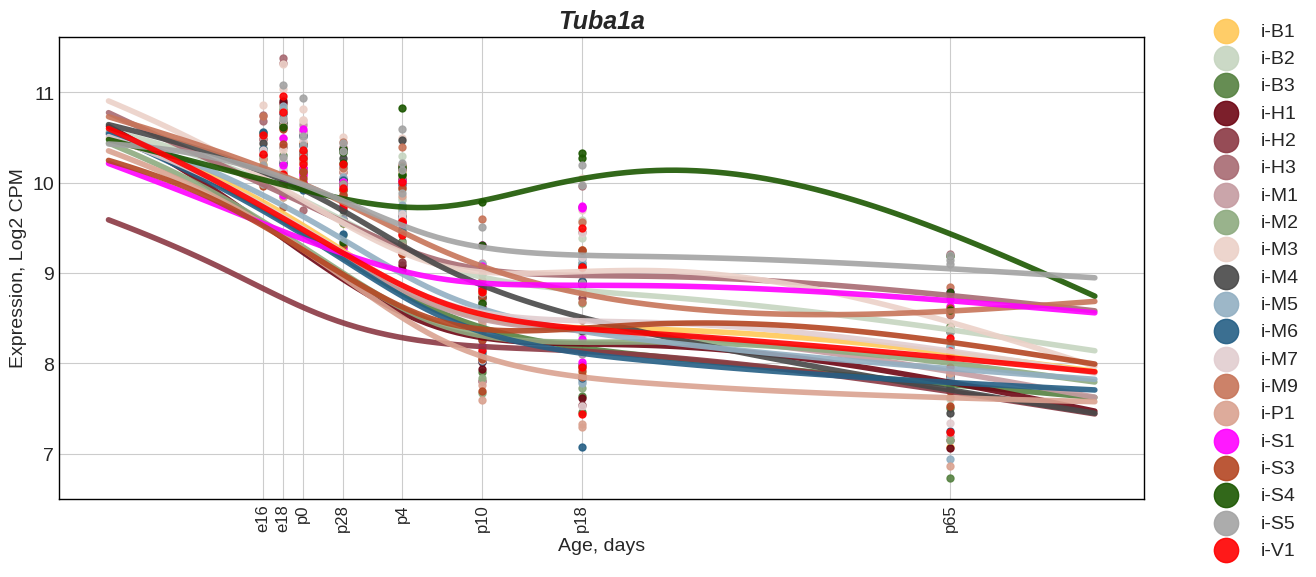

In [57]:
#plot_clusters_gene(["e-A1", "e-A2", "e-A3", 
#                    "e-F1", 
#                    "e-M1", "e-M2", "e-M3", "e-M4", 
#                    "e-M5", "e-M8", "e-M9", "e-M10", 
#                    "e-P1", "e-P2", "e-P3"], 'Tuba1a')
# remove i-S2, i-M8
plot_clusters_gene(["i-B1", "i-B2", "i-B3", 
                    "i-H1", "i-H2", "i-H3",
                    "i-M1", "i-M2", "i-M3",
                    "i-M4", "i-M5", "i-M6",
                    "i-M7", "i-M9", 
                    "i-P1", 
                    "i-S1", "i-S3", "i-S4",
                    "i-S5",
                    "i-V1"],"Tuba1a")

[16, 18, 20, 30, 38, 48, 24, 85]


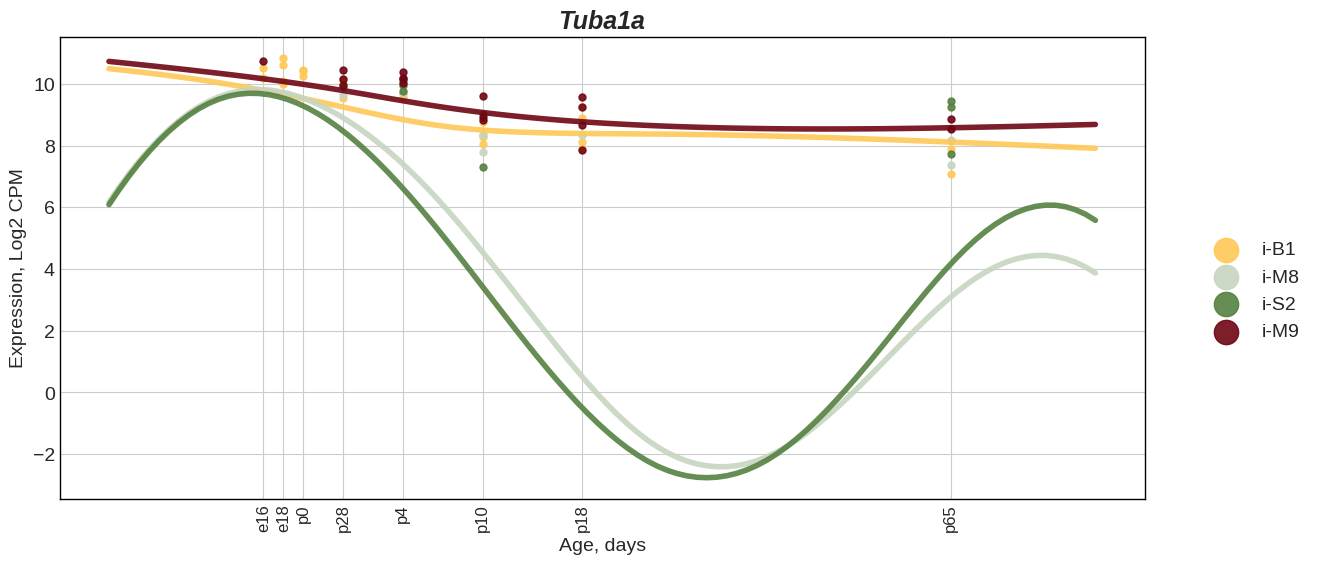

In [58]:
plot_clusters_gene(["i-B1", "i-M8", "i-S2", "i-M9"], "Tuba1a")

## **Rate of Change Analysis**

In [43]:
#len(xticks)
# print(logTMMs["avpe"].columns.values)
# sorted(list(np.unique(np.array(ai_age))))
#n_grid_pts


In [59]:
# def plot_trend_changes(ref_keys, title, clust_order=adata.uns['major_clust_plot_order']):
# clus_plot_order = list of regions
def plot_trend_changes(ref_keys, title, clust_order = ["avpe"]):    
    # ref_keys = list(gam_fits.keys())
    # plt.figure(figsize=(12,4))
    #ref_key='e-A1'
    title = "Rate-of-change on Day scale"
    # for ref_key in clust_order[np.in1d(clust_order, ref_keys)]:
    i = 0
    for ref_key in ref_keys:
        cell_type_color = v_colors[i]
        i += 1
        # column names - aggregates
        # arc_ages = logTMMs[ref_key].columns.values
        arc_ages = ai_age
        arc_x = np.linspace(0, 100, n_grid_pts)
        year_x = arc_x
        # n_grid_pts declared earlier = 100
        #arc_x = np.linspace(min(arc_ages), max(arc_ages), n_grid_pts)
        #year_x = np.sinh(arc_x)*adata.uns['arcsinh_cofactor']
        #print(year_x)
        df = gam_fits[ref_key]
        min_max_scaler = preprocessing.MinMaxScaler()
        gene_norms = min_max_scaler.fit_transform(df.T).T
        norm_rates = np.diff(gene_norms, axis=1)/np.diff(year_x)
        diff_means = np.mean(np.abs(norm_rates), axis=0)
        #xx = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts-1)
        xx = np.linspace(0, 100, n_grid_pts-1)
        plt.plot(xx, diff_means,
                 color = cell_type_color, 
                 linewidth=2.5, label=ref_key)
        # all ages are present in L2-3 traj
        # xticks = logTMMs['avpe'].columns.values
        # xticks = [0, 1, 2, 3, 4, 5, 6, 7]
    xticks = sorted(list(np.unique(np.array(ai_age))))
    xlabels = ["e16", "e18", "p0", "p4", "p10", "p18", "p28", "p65"]
    plt.xticks(ticks = xticks, 
           labels = xlabels, 
           rotation = 90, fontsize = 10);
    plt.title(title, fontsize=18, weight='bold');
    plt.legend(bbox_to_anchor=(1.12, 0.45), loc="center");
    plt.show()
    return

#def plot_trend_changes_arcsinh( ref_keys, title, clust_order=adata.uns['major_clust_plot_order']):
#    plt.figure( figsize=(12,4))
#    for ref_key in clust_order[np.in1d( clust_order, ref_keys)]:
#        arc_ages = logTMMs[ref_key].columns.values
#        df = gam_fits[ref_key]
#        min_max_scaler = preprocessing.MinMaxScaler()
#        gene_norms = min_max_scaler.fit_transform( df.T).T
#        norm_rates = np.diff( gene_norms, axis=1)
#        diff_means = np.mean( np.abs(norm_rates), axis=0)
#        xx = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts-1)
#        plt.plot( xx, diff_means, color=adata.uns['major_clust_colors_dict'][ref_key], linewidth=2.5, label=ref_key)
#    # all ages are present in L2-3 traj
#    xticks = logTMMs['L2-3_CUX2'].columns.values
#    plt.xticks( ticks=xticks, labels=plot_labels['L2-3_CUX2'], rotation=90, fontsize=10);
#    plt.title( title, fontsize=18, weight='bold');
#    plt.legend( bbox_to_anchor=(1.12, 0.45), loc="center");
#    plt.show()
#    return

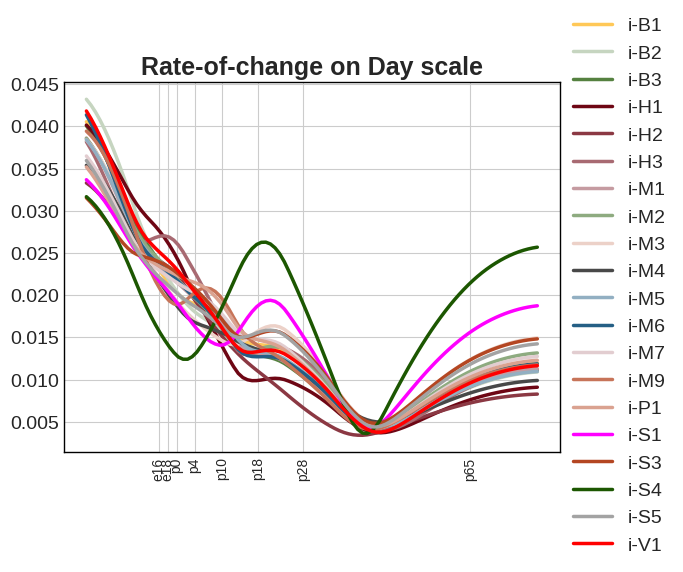

In [60]:
plot_clusters = ["i-B1", "i-B2", "i-B3", 
                    "i-H1", "i-H2", "i-H3",
                    "i-M1", "i-M2", "i-M3",
                    "i-M4", "i-M5", "i-M6",
                    "i-M7", "i-M9", 
                    "i-P1", 
                    "i-S1", "i-S3", "i-S4",
                    "i-S5",
                    "i-V1"]
plot_trend_changes(plot_clusters, 'Rate-of-Change on Day Scale')
#plot_trend_changes( list(gam_fits.keys()), 'Rate-of-Change on Day Scale')

In [167]:
# plot_trend_changes_arcsinh( list(gam_fits.keys()), 'Rate-of-Change on Arcsinh Scale');

In [61]:
def plot_trend_acc(ref_keys, title):
#, clust_order=adata.uns['major_clust_plot_order']):
    title = "Acceleration Rate of Change on Day scale"
    plt.figure(figsize=(12,4))
    i = 0
    for ref_key in ref_keys:
        cell_type_color = v_colors[i]
        i += 1
        # arc_ages = logTMMs[ref_key].columns.values
        arc_ages = ai_age
        arc_x = np.linspace(0, 100, n_grid_pts)
        year_x = arc_x
        # arc_x = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts)
        # year_x = np.sinh( arc_x)*adata.uns['arcsinh_cofactor']
        df = gam_fits[ref_key]
        min_max_scaler = preprocessing.MinMaxScaler()
        gene_norms = min_max_scaler.fit_transform(df.T).T
        norm_rates = np.diff(gene_norms, axis=1)/np.diff( year_x)
        norm_rates2 = np.diff( norm_rates)/np.diff( year_x[:-1])
        diff_means = np.mean( np.abs(norm_rates2), axis=0)
        # xx = np.linspace( 0, 7, n_grid_pts-2)
        xx = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts-2)
        plt.plot(xx, diff_means, color= cell_type_color, linewidth=2.5, label=ref_key)
        # all ages are present in L2-3 traj
        # xticks = logTMMs['avpe'].columns.values
    xticks = sorted(list(np.unique(np.array(ai_age))))
    xlabels = ["e16", "e18", "p0", "p4", "p10", "p18", "p28", "p65"]
    plt.xticks( ticks = xticks, labels = xlabels, rotation=90, fontsize=10);
    plt.title( title, fontsize=18, weight='bold');
    plt.legend( bbox_to_anchor=(1.12, 0.45), loc="center");
    plt.show()
    return

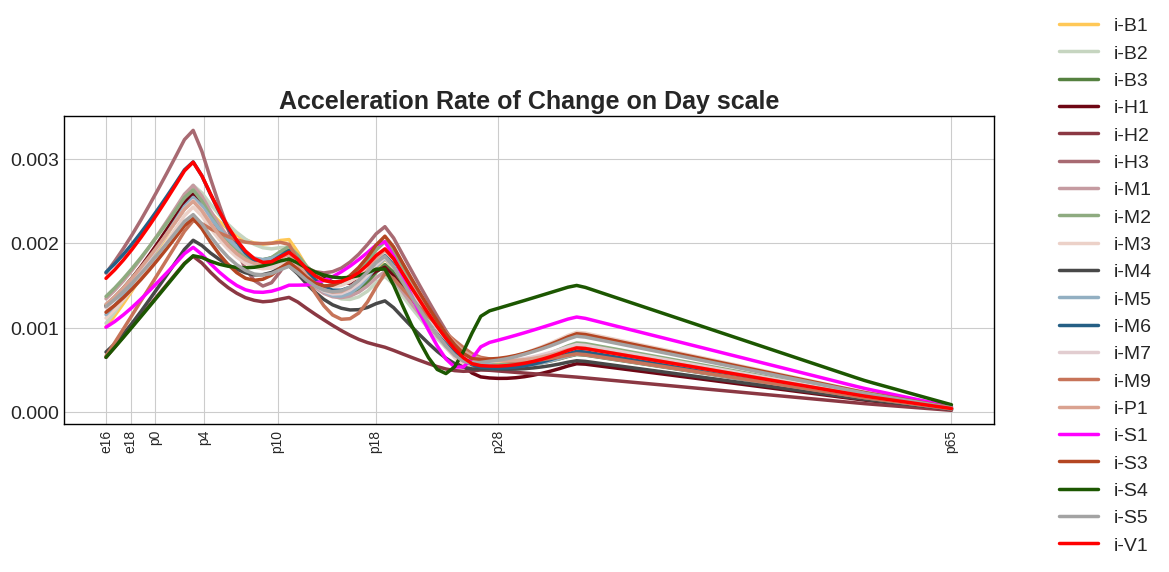

In [62]:
#plot_trend_acc(list(gam_fits.keys()), 'Acceleration Rate-of-Change on Day Scale')
plot_trend_acc(plot_clusters, 'Acceleration Rate-of-Change on Day Scale')

There are only 58 devDEGs in the microglia trajectory.